In [49]:
import numpy as np 
import tensorflow as tf
import matplotlib.pyplot as plt 
import tensorflow.compat.v1 as tf1
np.set_printoptions(precision=4)

from __future__ import absolute_import, division, print_function, unicode_literals

In [3]:
# constructing dataset 
dataset = tf.data.Dataset.from_tensor_slices([8, 3, 0, 8, 2, 1])
dataset

<_TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int32, name=None)>

In [4]:
for elem in dataset : 
    print(elem.numpy())

8
3
0
8
2
1


In [5]:
it = iter(dataset)
print(next(it).numpy())

8


In [6]:
# initial state = 0 
print(dataset.reduce(0, lambda state, value: state + value).numpy())

22


### Dataset structure 

In [7]:
dataset1 = tf.data.Dataset.from_tensor_slices(tf.random.uniform([4, 10]))
dataset1.element_spec #inspect type of each elem

TensorSpec(shape=(10,), dtype=tf.float32, name=None)

In [8]:
dataset2 = tf.data.Dataset.from_tensor_slices((
    tf.random.uniform([4]),
    tf.random.uniform([4, 100], maxval = 100, dtype = tf.int32)    
))
dataset2.element_spec 

(TensorSpec(shape=(), dtype=tf.float32, name=None),
 TensorSpec(shape=(100,), dtype=tf.int32, name=None))

In [9]:
dataset3 = tf.data.Dataset.zip((dataset1, dataset2))
dataset3.element_spec

(TensorSpec(shape=(10,), dtype=tf.float32, name=None),
 (TensorSpec(shape=(), dtype=tf.float32, name=None),
  TensorSpec(shape=(100,), dtype=tf.int32, name=None)))

In [10]:
dataset4 = tf.data.Dataset.from_tensor_slices(
    tf.SparseTensor(
        indices = [[0, 0], [1, 2]], values = [1, 2], 
        dense_shape = [3, 4]
    )
)
print(dataset4.element_spec)
print(dataset4.element_spec.value_type)

SparseTensorSpec(TensorShape([4]), tf.int32)
<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>


In [11]:
dataset5 = tf.data.Dataset.from_tensor_slices(
    tf.random.uniform([4, 10], minval = 1, maxval = 10, dtype = tf.int32)
)
dataset5

<_TensorSliceDataset element_spec=TensorSpec(shape=(10,), dtype=tf.int32, name=None)>

### Batching Dataset 

#### Simple batching

In [12]:
inc_dataset = tf.data.Dataset.range(100)
dec_dataset = tf.data.Dataset.range(0, -100, -1)
dataset = tf.data.Dataset.zip((inc_dataset, dec_dataset))
batched_dataset = dataset.batch(4)

itr = iter(batched_dataset)
for batch in batched_dataset.take(5) : 
    print([arr.numpy() for arr in batch])

[array([0, 1, 2, 3], dtype=int64), array([ 0, -1, -2, -3], dtype=int64)]
[array([4, 5, 6, 7], dtype=int64), array([-4, -5, -6, -7], dtype=int64)]
[array([ 8,  9, 10, 11], dtype=int64), array([ -8,  -9, -10, -11], dtype=int64)]
[array([12, 13, 14, 15], dtype=int64), array([-12, -13, -14, -15], dtype=int64)]
[array([16, 17, 18, 19], dtype=int64), array([-16, -17, -18, -19], dtype=int64)]


In [13]:
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [14]:
batched_dataset = dataset.batch(7, drop_remainder = True)
batched_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(7,), dtype=tf.int64, name=None), TensorSpec(shape=(7,), dtype=tf.int64, name=None))>

#### Batching tensor with padding 

In [15]:
dataset = tf.data.Dataset.range(100)
dataset = dataset.map(lambda x: tf.fill([tf.cast(x, tf.int32)], x))
dataset = dataset.padded_batch(4, padded_shapes = (None, ))

for batch in dataset.take(2) : 
    print(batch.numpy())
    print()

[[0 0 0]
 [1 0 0]
 [2 2 0]
 [3 3 3]]

[[4 4 4 4 0 0 0]
 [5 5 5 5 5 0 0]
 [6 6 6 6 6 6 0]
 [7 7 7 7 7 7 7]]



### Training workflow 

In [16]:
titanic_file = tf.keras.utils.get_file('train.csv', 'https://storage.googleapis.com/tf-datasets/titanic/train.csv')
titanic_lines = tf.data.TextLineDataset(titanic_file)

In [17]:
def plot_batch_size(ds) : 
    batch_size = [batch.shape[0] for batch in ds]
    plt.bar(range(len(batch_size)), batch_size)
    plt.xlabel("btach number")
    plt.xlabel("btach size")
    plt.show();

applying `Dataset.repeat()` transformation with no arguments will repeat the input indefinitely. 

The `Dataset.repeat()` transformation concatenates ita arguments without signaling the end of one epocj and the beginning of the next epoch. Because of this a `Dataset.batch` applied after `Dataset.repeat` will yield batched that stradke epoch boundaries.

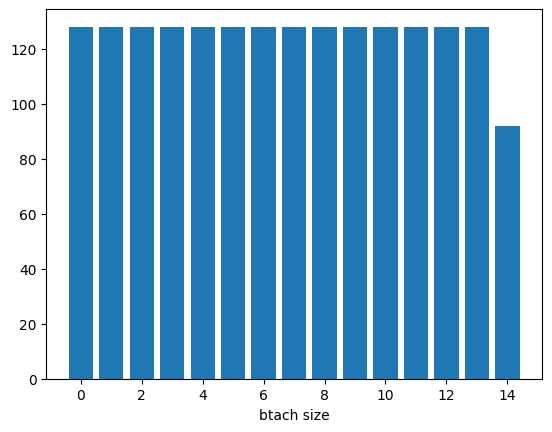

In [18]:
titanic_batches = titanic_lines.repeat(3).batch(128)
plot_batch_size(titanic_batches)

If you need clear epoch seperation, put `Dataset.batch` before repeat

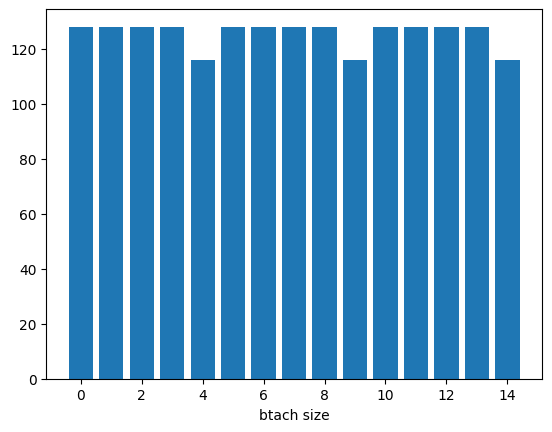

In [19]:
titanic_batches = titanic_lines.batch(128).repeat(3)
plot_batch_size(titanic_batches)

In [20]:
epochs = 3 
dataset = titanic_lines.batch(128)

for epoch in range(epochs) : 
    for batch in dataset : 
        print(batch.shape)
    print('End of epoch : ', epoch)

(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch :  0
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch :  1
(128,)
(128,)
(128,)
(128,)
(116,)
End of epoch :  2


#### Randomly shuffling input data

In [21]:
lines = tf.data.TextLineDataset(titanic_file)
counter = tf.data.experimental.Counter()

dataset = tf.data.Dataset.zip((counter, lines))
dataset = dataset.shuffle(buffer_size=100)
dataset = dataset.batch(20)
dataset

Instructions for updating:
Use `tf.data.Dataset.counter(...)` instead.


<_BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [22]:
n, line_batch = next(iter(dataset))
print(n.numpy()) # no value over 120 

[ 22  36   4  64  49  74  97  45  92  44  68  58   2  72 104  17  21  18
  57 110]


In [23]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.shuffle(buffer_size=100).batch(10).repeat(2)

print("Here are the item ID's near the epoch boudary: \n")
for n, line_batch in shuffled.skip(60).take(5) :
    print(n.numpy())

Here are the item ID's near the epoch boudary: 

[590 237 151 591 625 488 559 627 560 455]
[329 341 505 621 579 606 525 458 252 453]
[626 615 610  92 604 589 572 614]
[ 67  53  27  89  15  70 100 104  65  38]
[ 40  59  61  56  43  28  22 103 110 118]


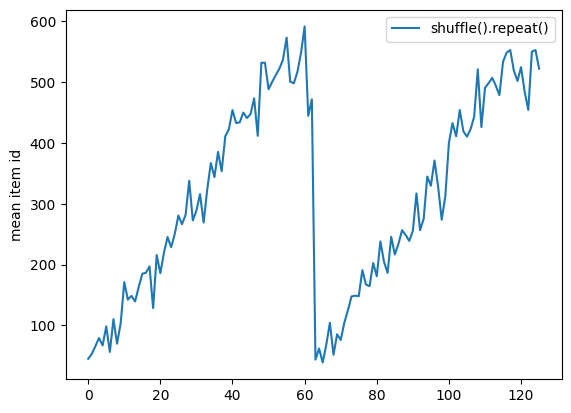

In [24]:
shuffle_repeat = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label = "shuffle().repeat()")
plt.ylabel("mean item id") 
plt.legend();

In [25]:
dataset = tf.data.Dataset.zip((counter, lines))
shuffled = dataset.repeat(2).shuffle(buffer_size=100).batch(10)

print("Here are the item ID's near the epoch boudary: \n")
for n, line_batch in shuffled.skip(55).take(15) :
    print(n.numpy())

Here are the item ID's near the epoch boudary: 

[586 570  18 227 499 577  27 610 178  22]
[  1 402 470 544 614 585   9  35  25 557]
[366 211 589  37  14  40 553 392  31  26]
[ 41 580   6 525  36   7 605 600 493 473]
[ 39 604  20  48 454  56 578  45  61 550]
[480 622  15  44  24  12  72 602 531  78]
[503 496   5  47  82 554 623  16 596  88]
[569  46 620 566  62 201 479  32  79  98]
[594 483 102  28 101  76  69  91 560  33]
[  3  17  52 520 609 624 556 608 114 110]
[111 618 555  34   8  75  81  94 117  85]
[112 126 115  38   0  57  53 548  65 135]
[113 592  11 141 109 123 129 116  93 486]
[ 86 617  87  19  67 100  66 157  80  97]
[120   2 151  29 108 397  10  99 124 146]


`shuffle.repeat()` make sure that each element in the epoch is present in the training data where as `repeat().shuffle()` doesn't guarantee that 

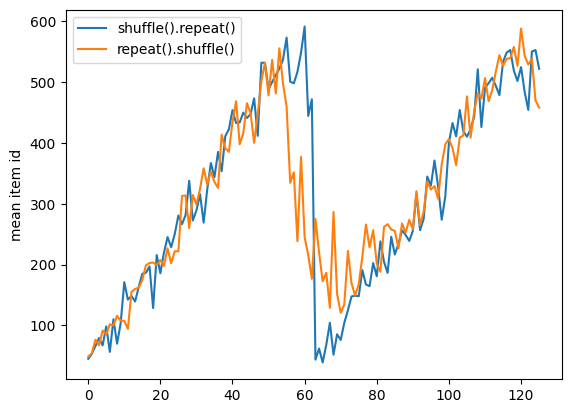

In [26]:
repeat_shuffle = [n.numpy().mean() for n, line_batch in shuffled]
plt.plot(shuffle_repeat, label = "shuffle().repeat()")
plt.plot(repeat_shuffle, label = "repeat().shuffle()")
plt.ylabel("mean item id") 
plt.legend();

#### Preprocessing data 

In [27]:
flowers = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True
)

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 23s 0us/step


In [28]:
flowers

'C:\\Users\\ghora\\.keras\\datasets\\flower_photos'

In [29]:
list_ds = tf.data.Dataset.list_files(str(flowers+"/*/*"))
list_ds

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

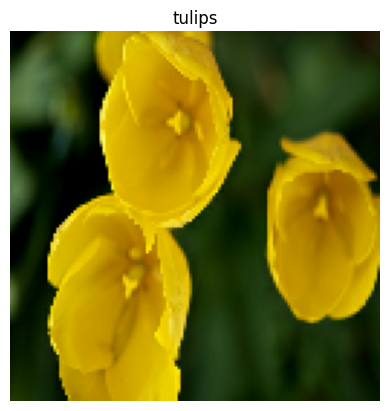

In [30]:
def parse_image(filename) : 
    parts = tf.strings.split(file_path, '\\') 
    label = parts[-2]

    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [128, 128])
    return image, label 

file_path = next(iter(list_ds))
image, label = parse_image(file_path)

def show(image, label) : 
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy().decode('utf-8'))
    plt.axis('off')

show(image, label)

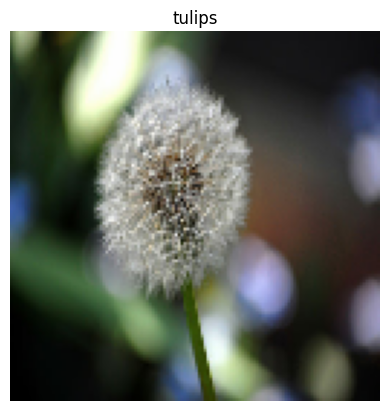

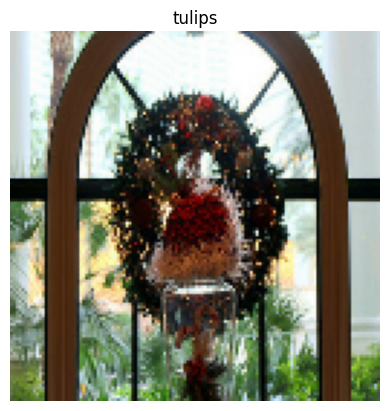

In [31]:
image_ds = list_ds.map(parse_image)
for image, label in image_ds.take(2) : 
    show(image, label)

#### Arbitrary python logic 

In [32]:
import scipy.ndimage as ndimage 

def random_rotate_image(image) : 
    image = ndimage.rotate(image, np.random.uniform(-30, 30), reshape=False)
    return image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


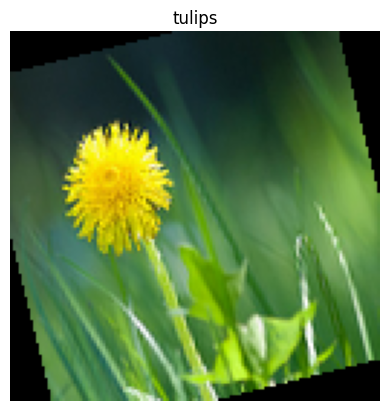

In [33]:
image, label = next(iter(image_ds))
image = random_rotate_image(image)
show(image, label)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


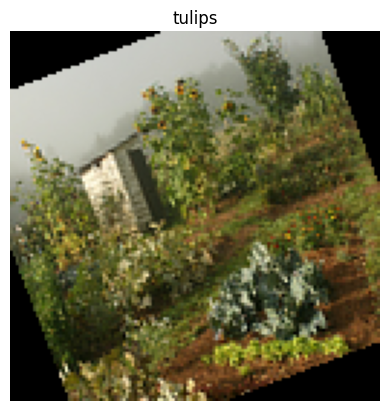

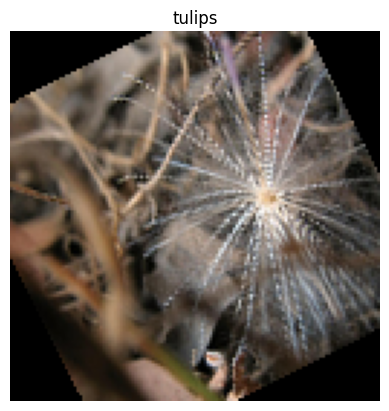

In [34]:
def tf_random_rotate_image(image, label) :
    im_shape = image.shape 
    # wrapping random_rotate_image
    [image, ] = tf.py_function(random_rotate_image, [image], [tf.float32])
    image.set_shape(im_shape)
    return image, label

rot_ds = image_ds.map(tf_random_rotate_image)
for image, label in rot_ds.take(2) : 
    show(image, label)

### Using high-level APIs

In [35]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

images, labels = train
images = images/255.0 
labels = labels.astype(np.int32)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [36]:
fmnist_train_ds = tf.data.Dataset.from_tensor_slices((images, labels))
fmnist_train_ds = fmnist_train_ds.shuffle(5000).batch(32)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
    metrics = ['accuracy']
)

In [37]:
model.fit(fmnist_train_ds, epochs=2)

Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7465 - loss: 0.7616
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8410 - loss: 0.4686


if we pass an infinite dataset, by calling `Dataset.repeat()` we need to also pass the `steps_per_epoch` argument 

In [38]:
model.fit(fmnist_train_ds.repeat(), epochs=2, steps_per_epoch=20)

Epoch 1/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8866 - loss: 0.3661 
Epoch 2/2
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8381 - loss: 0.4565


In [39]:
loss, accuracy = model.evaluate(fmnist_train_ds)
print('loss : ', loss)
print('accuracy : ', accuracy)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8506 - loss: 0.4370 
loss :  0.43396878242492676
accuracy :  0.8511833548545837


for large datasets set number of steps to evaluate 

In [40]:
loss, accuracy = model.evaluate(fmnist_train_ds.repeat(), steps = 10)
print('loss : ', loss)
print('accuracy : ', accuracy)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8391 - loss: 0.4199 
loss :  0.3730701208114624
accuracy :  0.8687499761581421


In [41]:
result = model.predict(fmnist_train_ds, steps = 10)
print(result.shape)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(320, 10)


### tf.etimator 

In [46]:
import tensorflow_datasets as tfds

def train_input_fn() : 
    titanic = tf.data.experimental.make_csv_dataset(
        titanic_file, batch_size=32, label_name='survived'
    )
    titanic_batches = (
        titanic.cache().repeat().shuffle(500)
        .prefetch(tf.data.experimental.AUTOTUNE) # the batch is fetched before time so the training isn't stalled
    )
    return titanic_batches

In [47]:
# converting non numerical columns into numerical cols 
embark = tf.feature_column.categorical_column_with_hash_bucket('embark_town', 32)
clss = tf.feature_column.categorical_column_with_vocabulary_list(
    'class', ['First', 'Second', 'Third']
)
age = tf.feature_column.numeric_column('age')

Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.
Instructions for updating:
Use Keras preprocessing layers instead, either directly or via the `tf.keras.utils.FeatureSpace` utility. Each of `tf.feature_column.*` has a functional equivalent in `tf.keras.layers` for feature preprocessing when training a Keras model.


`TensorFlow 2.15` included the final release of the tf-estimator package. Estimators will not be available in `TensorFlow 2.16` or after.

In [ ]:
import tempfile 

model_dir = tempfile.mkdtemp()
model = tf.estimator.LinearClassifier(
    model_dir = model_dir, feature_columns = [embark, clss, age], 
    n_classes = 2
)

model = model.train(input_fn = train_input_fn, steps = 100) 

result = model.evaluate(train_input_fn, steps = 10)
for key, value in result.items() : 
    print(key, " : ", value)

for pred in model.predict(train_input_fn) : 
    for key, value in pred.items() : 
        print(key, " : ", value)
    break 